# Brexit Polarity Tweets - Feature Extraction

## Setup

In [1]:
import os
import re
import nltk

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP and ML Tools
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
# define helper functions
def read_tweet(filepath):
    tweets = []
    with open(filepath, "r") as f:
        for tweet in f:
            tweets.append(tweet.replace("\n", ""))
    return pd.Series(tweets)

def plot_freqdist(freqdist, n = 30):
    """Plot n-most frequent tokens of a FreqDist"""
    plt.figure(figsize=(12,3))
    freqdist.plot(n)
    plt.show()

In [3]:
# settings
N_FEATURES = 300 # for each feature groups (i.e., tokens, counts, tf-idf)

PATH_DATA  = "./data/"
PATH_TRAIN = PATH_DATA + "preprocessed/train/"
PATH_TEST  = PATH_DATA + "preprocessed/test/"
PATH_FEATURE_TRAIN = PATH_DATA + "features/train/"
PATH_FEATURE_TEST = PATH_DATA + "features/test/"

In [4]:
tweets  = read_tweet(PATH_TRAIN + "0-clean.txt")[:5000]
targets = read_tweet(PATH_TRAIN + "0-targets.txt")[:5000]

In [5]:
label_encoder = LabelEncoder()
tokenizer     = TweetTokenizer()

## Frequency Distributions

In [6]:
def get_freqdist(tweets):
    # create a variable to store frequency distribution based on label
    fdist = nltk.ConditionalFreqDist()

    # calculate the frequency of tokens based on label
    for index, tweet in zip(tweets.index, tweets):
        for token in tokenizer.tokenize(tweet):
            condition = targets[index]
            fdist[condition][token] += 1

    # remove shared tokens for each type of users
    common_tokens = set(fdist["Pro"]).intersection(fdist["Anti"])

    for token in common_tokens:
        del fdist["Pro"][token]
        del fdist["Anti"][token]
        
    return fdist

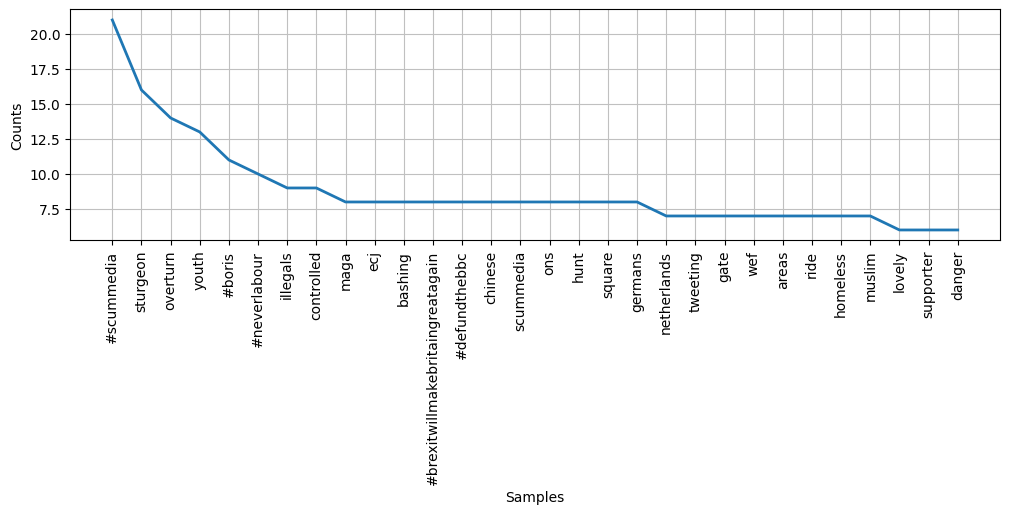

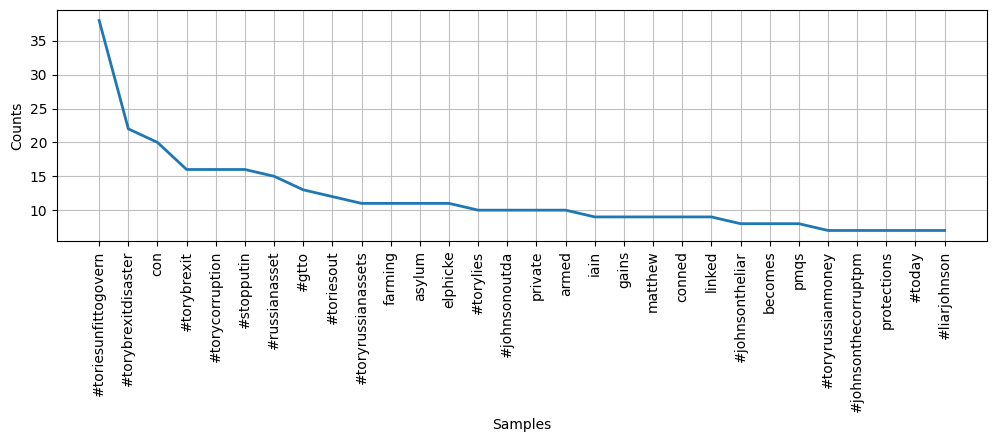

In [7]:
# sample
fd_tokens = get_freqdist(tweets)

# visualize top tokens from pro-Brexit users' tweet
plot_freqdist(fd_tokens["Pro"])

# visualize top tokens from anti-Brexit users' tweet
plot_freqdist(fd_tokens["Anti"])

## Feature 1: Tokens

In [8]:
def extract_tokens(tweets, n_features = 50):
   n_each = np.ceil(n_features / 2).astype(int)
   
   fdist = get_freqdist(tweets)

   vocabs = [token for token, count in fdist["Anti"].most_common(n_each)]
   vocabs += [token for token, count in fdist["Pro"].most_common(n_each)]
   
   count_vectorizer = CountVectorizer(vocabulary = vocabs,
                                      tokenizer = lambda tweet: tokenizer.tokenize(tweet),
                                      token_pattern = None, # r"\S+", # non white space
                                      binary = True,
                                      lowercase = False)
   
   token_names = count_vectorizer.get_feature_names_out()
   
   counts = count_vectorizer.fit_transform(tweets).toarray()
   
   return pd.DataFrame(counts, columns = f"has(" + token_names + ")")

In [9]:
extract_tokens(tweets[:5], 6)

,has(oliver),has(dowden),has(shameless),has(the),has(to),has(on)
0,1,1,1,0,0,0
1,0,0,0,1,1,1
2,0,0,0,1,1,1
3,0,0,0,0,0,0
4,0,0,0,1,0,1


## Feature 2: Term Frequency

In [10]:
def extract_counts(tweets, n_features = 50):
   n_each = np.ceil(n_features / 2).astype(int)
   
   fdist = get_freqdist(tweets)

   vocabs = [token for token, count in fdist["Anti"].most_common(n_each)]
   vocabs += [token for token, count in fdist["Pro"].most_common(n_each)]

   count_vectorizer = CountVectorizer(vocabulary = vocabs,
                                      tokenizer = lambda tweet: tokenizer.tokenize(tweet),
                                      token_pattern = None, # r"\S+", # non white space
                                      lowercase = False)

   token_names = count_vectorizer.get_feature_names_out()

   counts = count_vectorizer.fit_transform(tweets).toarray()

   return pd.DataFrame(counts, columns = f"count(" + token_names + ")")

In [11]:
extract_counts(tweets[:5], 6) # the data is sparse

,count(oliver),count(dowden),count(shameless),count(the),count(to),count(on)
0,1,1,1,0,0,0
1,0,0,0,6,2,2
2,0,0,0,2,2,1
3,0,0,0,0,0,0
4,0,0,0,5,0,1


## Feature 3: TF-IDF

In [12]:
def extract_tfidfs(tweets, n_features = 50):
    n_each = np.ceil(n_features / 2).astype(int)

    fdist = get_freqdist(tweets)

    vocabs = [token for token, count in fdist["Anti"].most_common(n_each)]
    vocabs += [token for token, count in fdist["Pro"].most_common(n_each)]
    
    tfidf_vectorizer = TfidfVectorizer(vocabulary = vocabs,
                                       tokenizer = lambda tweet: tokenizer.tokenize(tweet),
                                       token_pattern = None, # r"\S+", # non white space
                                       lowercase = False)
    
    token_names = tfidf_vectorizer.get_feature_names_out()
    
    tfidfs = tfidf_vectorizer.fit_transform(tweets).toarray()
    
    return pd.DataFrame(tfidfs, columns = "tfidf(" + token_names + ")")

In [13]:
extract_tfidfs(tweets[:5], 6) # the data is sparse

,tfidf(oliver),tfidf(dowden),tfidf(shameless),tfidf(the),tfidf(to),tfidf(on)
0,0.57735,0.57735,0.57735,0.000000,0.000000,0.000000
1,0.00000,0.00000,0.00000,0.886532,0.355998,0.295511
2,0.00000,0.00000,0.00000,0.608437,0.732977,0.304219
3,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
4,0.00000,0.00000,0.00000,0.980581,0.000000,0.196116


## Combining All Features 

In [14]:
def extract_all_features(tweets, n_features):
    ft_tokens     = extract_tokens(tweets, n_features)
    ft_counts     = extract_counts(tweets, n_features)
    ft_tfidfs     = extract_tfidfs(tweets, n_features)
    
    return pd.concat([ft_tokens, ft_counts, ft_tfidfs], axis = 1)

In [15]:
tweet_files = [f for f in os.listdir(PATH_TRAIN) if re.match(".*nostw.*", f)]
targets = read_tweet(PATH_TRAIN + "0-targets.txt") # re-import for all rows

for tweet_file in tweet_files:
    print(tweet_file)
    
    tweets_train = read_tweet(PATH_TRAIN + tweet_file)
    tweets_test = read_tweet(PATH_TEST + tweet_file)
    
    features_train = extract_all_features(tweets_train, n_features = N_FEATURES)
    features_test = extract_all_features(tweets_test, n_features = N_FEATURES)
    
    features_train.to_csv(PATH_FEATURE_TRAIN + tweet_file.replace("txt", "csv"), index = False)
    features_test.to_csv(PATH_FEATURE_TEST + tweet_file.replace("txt", "csv"), index = False)

1-clean-nostw.txt
2-clean-nostw-lemma.txt
2-clean-nostw-negat.txt
3-clean-nostw-lemma-negat.txt
